<a href="https://colab.research.google.com/github/cyss93/CP1_team8/blob/%EC%98%A4%EC%B0%BD%EC%98%81/Whale_Curve_%26_Origins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats

In [30]:
df_seller =  pd.read_csv('EDA_seller_data.csv')
df_order =  pd.read_csv('EDA_order_data.csv')

### seller_data 데이터 설명
- seller_id	: 판매자 번호 (아이디)
- origin : Olist 유입 경로
- landing_page_id : Olist 유입시 랜딩된 페이지
- date_for_registration : 판매자 신청부터 등록까지 소요된 시간
- business_type : 영업 방식 (중간 유통, 제작자 등)
- lead_type : 영업 형태
- business_segment : 취급 물품
- seller_state : 판매 위치 (주)
- mean_distance : 평균 판매 거리
- sale_days : 등록 이후 영업 날짜
- total_profit : 총 수익
- LTV : 하루 평균 매출 기대값
- seller_status : 판매자 이탈 여부 (최근 60 일간 판매가 없을 시 이탈로 간주)

### order_data 데이터 설명
- order_id : 주문 번호 (아이디)
- product_id : 제품 번호 (아이디)
- order_item_id	: 제품 구분 번호 (동일 제품 다수 구매시 중복 데이터로 처리 되는것을 방지)
- price : 가격
- freight_value : 운송료
- seller_profit	: 판매자의 수익 = 가격 - 운송료
- distance : 주문 배달 거리
- order_approved_at : 결제 승인 시각
- seller_id : 판매자 번호 (아이디)

# 적용 개념들
- Whale curves
  - 상위 20%가 매출의 80%를 차지하는것이 아닌, 상위 1%가 매출의 80%를 차지한다면, 기형적인 구조이기 때문에 다양한 문제가 발생할 수 있다. 그렇기때문에 이 구조를 보고 진단할 필요가 있음
- 산업/지역/제품의 집중도
  - 산업과 지역, 제품 등의 규모가 한 쪽으로 치우쳐 있다면, 비즈니스의 확장이나, 안정성 면에서 떨어지게 된다.
- Fragmentation(분산화 정도)
  - (판매자-구매자)의 비중이 (다수-소수), (다수-다수), (소수-다수) 등이 있는데, 마켓플레이스 입장에서 (소수-소수)인 경우에 미들맨의 역할이 중요하지 않기 때문에 위험한 상황이다. 가장 이상적인 모양은 (다수-다수)이다. 그렇기 때문에 Fragmentation을 확인해보고 서비스 상태를 확인할 필요가 있다.
- 참고링크: https://brunch.co.kr/@taewookim/17

### Whale curves
- '판매자의 수익성'을 Whale curve로 살펴보자
- 수익성의 계산 기준을 정하는게 우선
- 그냥 합계로 계산하기. 평균으로 계산하면 의미가 없어지니 주의할 것.
- 판매자들의 수익성 구간은 각 상위에서부터 10%씩 끊어서 정하고, 판매자의 수를 세보자
- 참고링크: https://m.blog.naver.com/bs2k/221595234106

In [31]:
df_seller.rename(columns = {'total_profit':'sum_revenue'}, inplace = True)

In [32]:
# 셀러 아이디와 수익성만 추출
df_for_whale = df_seller[['seller_id', 'sum_revenue']]

In [33]:
# 수익성 순으로 정렬
df_for_whale = df_for_whale.sort_values('sum_revenue')

In [34]:
df_for_whale.head(10)

,seller_id,sum_revenue
272,56e361f411e38dcef17cdc2a3d99628b,-559.76
192,9d213f303afae4983637247556438ede,-25.41
336,bb7ad8a45c027be8ab075b8e465f8ca0,-12.66
234,33d677f27a69b84051204ee4ae76eaca,-8.49
314,9b1f656ca3060f8af17a50d8a024b533,-6.68
351,455befea1bb853c75ccbca94cff26e5c,-2.07
308,5a4236931428800e9d9cc04af0987118,-0.72
189,8b181ee5518df84f18f4e1a43fe07923,0.82
284,539ed9e19811677513447759be5eccfc,1.74
291,2cb98e27ce1c18abdb42209b34c382a7,5.28


- 마이너스 수익을 가져온 셀러들은 어떻게 처리할까?
- 진입한지 얼마 안 된 판매자일 수 있다. 혹은 다른 요인들로 인해 적자를 보면서 판매를 진행하는 중일 수 있으니, 의미있는 데이터이기 때문에 가져가도록 하였다.

In [35]:
# # 한글 깨짐 방지
# # 아래 코드 실행 후 런타임 재시작 및 코드 실행 해주어야함
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [36]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

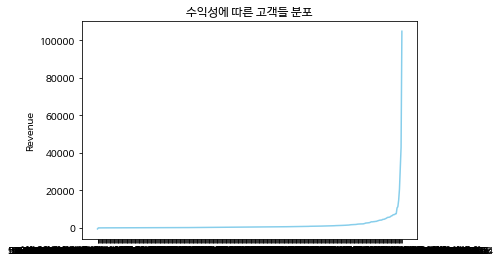

In [37]:
x_label = list(df_for_whale['seller_id'])
y_label = list(df_for_whale['sum_revenue'])

plt.plot(x_label, y_label,
         color='skyblue')

plt.title('수익성에 따른 고객들 분포')
plt.ylabel('Revenue')
plt.show()
plt.close()

- 판매자 별 수익성에 따라서 그래프를 그려보았다. 한 쪽으로 많이 치우쳐있는걸 볼 수 있으며, 먼저 고객들의 분포를 Boxplot으로 나타내보았다.

In [38]:
# 수익성(sum_revenue)으로 10% 구간 구하기
# pd.cut()은 동일한 길이로 나누는 것이고, pd.qcut()은 동일한 갯수로 나누는 것.

# 최소 수익성 판매자
min_revenue = df_for_whale['sum_revenue'].min()
max_revenue = df_for_whale['sum_revenue'].max()

In [39]:
min_revenue

-559.7600000000002

In [40]:
max_revenue

104805.89

In [41]:
# 10개 구간으로 나누고, 라벨을 붙여주기
# 예) 하위 10%까지는 라벨이 '0', 상위 10%는 라벨이 '9'
df_for_whale['ratio_revenue'] = pd.cut(df_for_whale['sum_revenue'], 10, 
                                       labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [42]:
df_for_whale.groupby('ratio_revenue')['ratio_revenue'].count()

ratio_revenue
0    372
1      3
2      1
3      1
4      1
5      0
6      0
7      0
8      0
9      1
Name: ratio_revenue, dtype: int64

- 구간을 총 10개로 나누고 각 구간별 판매자 수의 분포를 살펴보았다. 분포는 skew 되어있는 것을 볼 수 있었기에 Box plot그려보고 이상값을 확인해보았다.

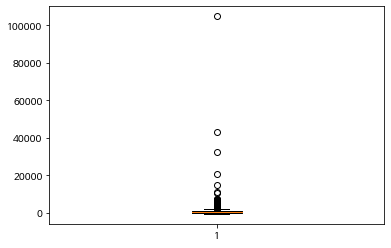

In [43]:
# box plot
plt.boxplot(df_for_whale['sum_revenue'])
plt.show()

- 박스가 제대로 그려지지도 않으며, 큰 이상값들이 존재하였다. 가장 큰 이상값 하나만 지우고 나서 분포를 다시 살펴보았다.

In [44]:
# 가장 큰 이상값 제거 하고 다시 그려보자
######## 여기서는 이상값이지만, 실제 큰 판매수익을 거둔 판매자이기에, 고래곡선 이외에서는 함부로 제외하면 안될 것 ########
df_for_whale_renew = df_for_whale[df_for_whale.sum_revenue != max_revenue]

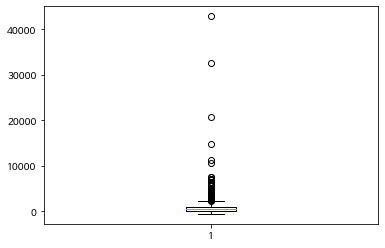

In [45]:
plt.boxplot(df_for_whale_renew['sum_revenue'])
plt.show()

- 아직 큰 이상값이 있다고 판단되지만, 일단 구간을 나눠보자

In [46]:
# 10개 구간으로 나누고, 라벨을 붙여주기
# 예) 하위 10%까지는 라벨이 '0', 상위 10%는 라벨이 '9'
df_for_whale_renew['ratio_revenue'] = pd.cut(df_for_whale_renew['sum_revenue'], 10, 
                                       labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# 분포 수
df_for_whale_renew.groupby('ratio_revenue')['ratio_revenue'].count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


ratio_revenue
0    349
1     23
2      2
3      1
4      1
5      0
6      0
7      1
8      0
9      1
Name: ratio_revenue, dtype: int64

- 제일 큰 이상값 하나만 제거했지만, 아직 많은 이상값들이 들어있는 것을 볼 수 있다.
- 이상치 제거하는 방식 중 IQR 활용해서 진행한 뒤 확인해보자
- IQR 참고 링크
 - https://fhaktj8-18.tistory.com/entry/%ED%8C%90%EB%8B%A4%EC%8A%A4-pandas-IQR-%ED%99%9C%EC%9A%A9%ED%95%B4%EC%84%9C-%EC%9D%B4%EC%83%81%EC%A0%90outlier-%EC%B0%BE%EA%B3%A0-%EC%82%AD%EC%A0%9C%ED%95%98%EA%B8%B0
 - https://jimmy-ai.tistory.com/260

In [47]:
# 먼저 사분위수 구하기위해서 describe()로 확인
df_for_whale_renew['sum_revenue'].describe()

count      378.000000
mean      1248.387593
std       3356.308471
min       -559.760000
25%        121.425000
50%        411.425000
75%        986.060000
max      42901.500000
Name: sum_revenue, dtype: float64

In [48]:
# Q1 - 1.5*IQR = 최소값
# Q3 + 1.5*IQR = 최대값

# 위 공식을 바탕으로 IQR 구하기(이상점)
## IQR은 InterQuartile Range의 줄임말. Q1과 Q3 사이 값. 박스 플롯 기본 수치
Q1 = df_for_whale_renew['sum_revenue'].quantile(0.25)
Q2 = df_for_whale_renew['sum_revenue'].quantile(0.5)
Q3 = df_for_whale_renew['sum_revenue'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

864.635


In [49]:
# 필터 설정
## IQR 기준으로 공식값에 대입해서 이상값 제거
condition = df_for_whale_renew['sum_revenue'] < (Q3 + 1.5*IQR)
df_for_whale_renew = df_for_whale_renew[condition]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


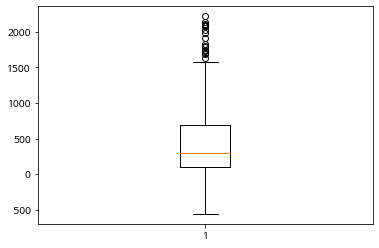

In [50]:
# 이제 다시 Box plot
plt.boxplot(df_for_whale_renew['sum_revenue'])
plt.show()

- 먼저 Box plot의 형태가 그려지는 것을 볼 수 있다. 하지만 분포가 한쪽으로 많이 skew 되어있기 때문에 고래곡선을 통해서 판매자 분포를 확인해 볼 필요가 있어보인다.

In [51]:
# 다시 구간 확인
# 10개 구간으로 나누고, 라벨을 붙여주기
# 예) 하위 10%까지는 라벨이 '0', 상위 10%는 라벨이 '9'
df_for_whale_renew['ratio_revenue'] = pd.cut(df_for_whale_renew['sum_revenue'], 10, 
                                       labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# 분포 수
df_for_whale_renew.groupby('ratio_revenue')['ratio_revenue'].count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


ratio_revenue
0      1
1      4
2    153
3     71
4     34
5     28
6     17
7      7
8      8
9      9
Name: ratio_revenue, dtype: int64

- 해당 분포를 이용해서 고래곡선을 그려보자

In [52]:
# 각 '구간'별 판매자들의 인원 수를 count
df_finally_whale = pd.DataFrame(df_for_whale_renew.groupby('ratio_revenue')['ratio_revenue'].count())

In [53]:
# 컬럼 이름 바꿔주기.
df_finally_whale.rename(columns = {'ratio_revenue':'num_of_ratio'}, inplace = True)
# 인덱싱 새로해주기
df_finally_whale.reset_index(drop = False, inplace = True)

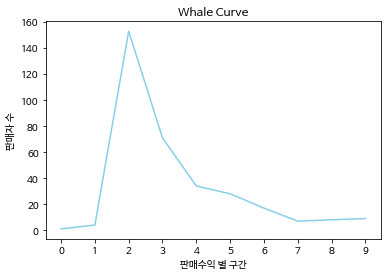

In [54]:
x_label = list(df_finally_whale['ratio_revenue'])
y_label = list(df_finally_whale['num_of_ratio'])

plt.plot(x_label, y_label,
         color='skyblue')

plt.title('Whale Curve')
plt.xlabel('판매수익 별 구간')
plt.ylabel('판매자 수')
plt.show()
plt.close()

- 전혀 고래 모양이 아니다. 해당 현상을 보고 서비스의 수익구조, 판매자 유형 분포 구조가 이상적인 구조가 아니라고 판단할 수 있다. 이에 판매자들의 유형이 Whale Curve를 그릴 수 있는 개선방안이 필요할 것으로 예상된다.